In [ ]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.svm import SVC
from collections import deque
from imutils import face_utils
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [6]:
# Specify the directory and image file name
directory = "train/angry"
image_file = "Training_3908.jpg"  # Ensure the file extension is correct
image_path = os.path.join(directory, image_file)

# Check if the file exists
if os.path.exists(image_path):
    print(f"Image found at: {image_path}")
    # Open and display the image using PIL
    img = Image.open(image_path)
    img.show()  # Opens the image in the default image viewer
else:
    print(f"Image file not found: {image_path}")

Image found at: train/angry\Training_3908.jpg


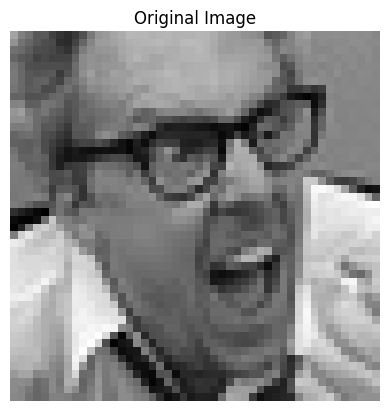

(48, 48, 3)


In [7]:
image = cv2.imread("train/angry/Training_3908.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")  
plt.title("Original Image")
plt.show()
print(image.shape)

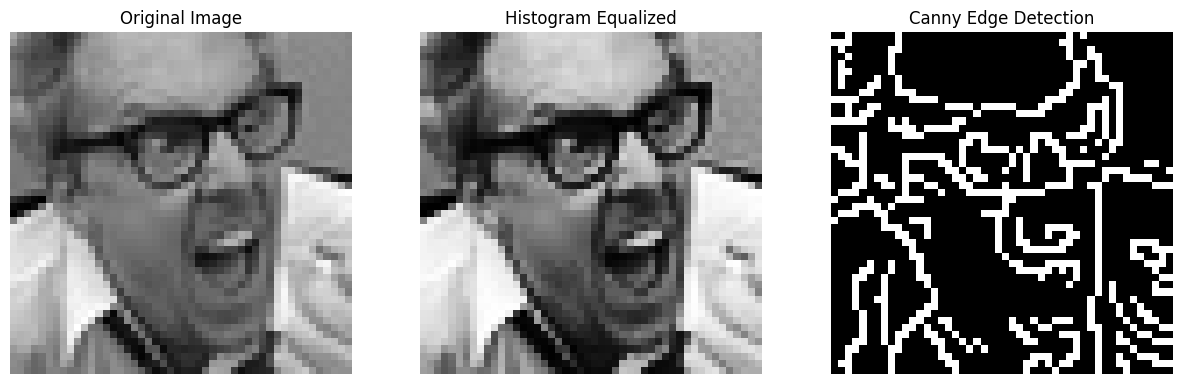

In [8]:
# Load Image
image = cv2.imread("train/angry/Training_3908.jpg", cv2.IMREAD_GRAYSCALE)

# Apply Histogram Equalization for contrast enhancement
equalized_image = cv2.equalizeHist(image)

# Apply Gaussian Blur for noise reduction
blurred_image = cv2.GaussianBlur(equalized_image, (3, 3), 0)

# Apply Edge Detection (Canny)
edges = cv2.Canny(blurred_image, 100, 200)

# Display Original and Processed Images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(equalized_image, cmap='gray')
axes[1].set_title("Histogram Equalized")
axes[1].axis("off")

axes[2].imshow(edges, cmap='gray')
axes[2].set_title("Canny Edge Detection")
axes[2].axis("off")

plt.show()


Image found at: train/angry\Training_3908.jpg


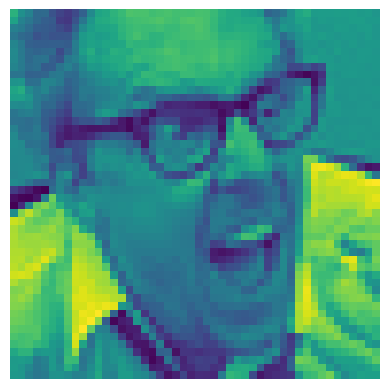

In [9]:
# Specify the directory and image file name
directory = "train/angry"
image_file = "Training_3908.jpg"  # Ensure the file extension is correct

# Construct the full path to the image
image_path = os.path.join(directory, image_file)

# Check if the file exists
if os.path.exists(image_path):
    print(f"Image found at: {image_path}")
    # Load and display the image
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide the axes
    plt.show()  # Display the image
else:
    print(f"Image file not found: {image_path}")

In [10]:
# Emotion Labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral' , 'Sad', 'Surprise']
num_classes = len(emotion_labels)

# Function to Load Images and Labels
def load_images_from_folder(base_path):
    X, y = [], []
    
    for emotion_index, emotion in enumerate(emotion_labels):
        folder_path = os.path.join(base_path, emotion.lower())  # e.g., "train/angry"
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            
            if image is not None:
                image = cv2.resize(image, (48, 48))  # Resize if necessary
                image = image / 255.0  # Normalize pixel values
                image = np.expand_dims(image, axis=-1)  # Reshape to (48, 48, 1)
                X.append(img_to_array(image))  # Convert to array
                y.append(emotion_index)  # Store corresponding label
    
    return np.array(X), np.array(y)

# Load Training & Testing Data
X_train, y_train = load_images_from_folder("train/")
X_test, y_test = load_images_from_folder("test/")

# Print Shapes
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")

Training Data Shape: (28709, 48, 48, 1), Testing Data Shape: (7178, 48, 48, 1)


In [11]:
print("Before Fixing:")
print("x_train shape:", X_train.shape)
print("x_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Before Fixing:
x_train shape: (28709, 48, 48, 1)
x_test shape: (7178, 48, 48, 1)
y_train shape: (28709,)
y_test shape: (7178,)


In [12]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=7)  # (28709, 7)
y_test = to_categorical(y_test, num_classes=7)  # (7178, 7)

print("Fixed y_train shape:", y_train.shape)  # (28709, 7)
print("Fixed y_test shape:", y_test.shape)  # (7178, 7)


Fixed y_train shape: (28709, 7)
Fixed y_test shape: (7178, 7)


In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

In [14]:
def build_cnn_model():
    emotion_model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # 7 classes
    ])

    emotion_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return emotion_model

# Create CNN Model
emotion_model = build_cnn_model()

# Print Model Summary
emotion_model.summary()


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,470,919 (9.43 MB)

 Trainable params: 2,470,919 (9.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train CNN Model
history = emotion_model.fit(X_train, y_train, 
                  epochs=50, 
                  batch_size=64, 
                  validation_data=(X_test, y_test))

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 166ms/step - accuracy: 0.2665 - loss: 1.7746 - val_accuracy: 0.4220 - val_loss: 1.5014
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 74s 165ms/step - accuracy: 0.4367 - loss: 1.4661 - val_accuracy: 0.4887 - val_loss: 1.3266
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.5001 - loss: 1.3094 - val_accuracy: 0.5283 - val_loss: 1.2364
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 88s 196ms/step - accuracy: 0.5422 - loss: 1.2065 - val_accuracy: 0.5481 - val_loss: 1.1892
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 169ms/step - accuracy: 0.5782 - loss: 1.1305 - val_accuracy: 0.5571 - val_loss: 1.1712
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - accuracy: 0.6024 - loss: 1.0595 - val_accuracy: 0.5510 - val_loss: 1.1791
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 168ms/step - accuracy: 0.6247 - loss: 0.9968 - val_accuracy: 0.5706 - val_loss: 1.1338
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 168ms/step - accuracy: 0.6515 - loss: 0

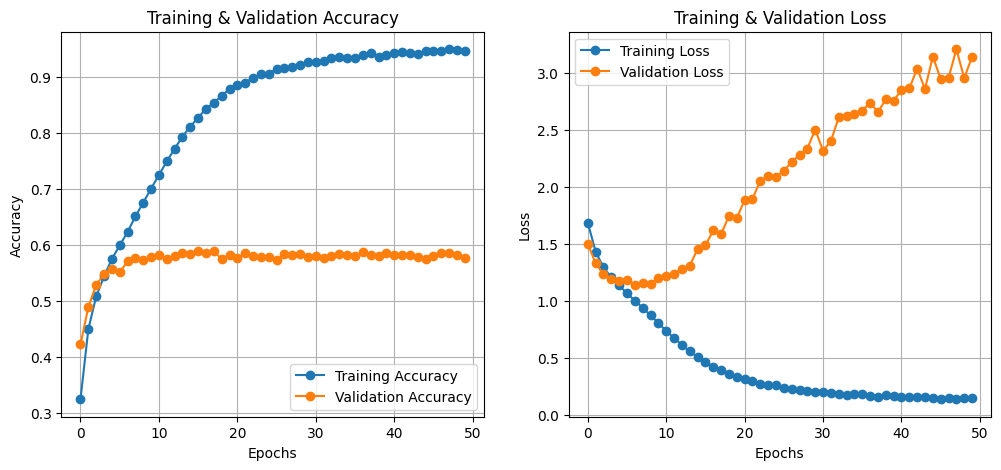

In [16]:
# Plot Accuracy Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [17]:
# Evaluate Model on Test Data
test_loss, test_acc = emotion_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5396 - loss: 3.4370
Test Accuracy: 0.5769


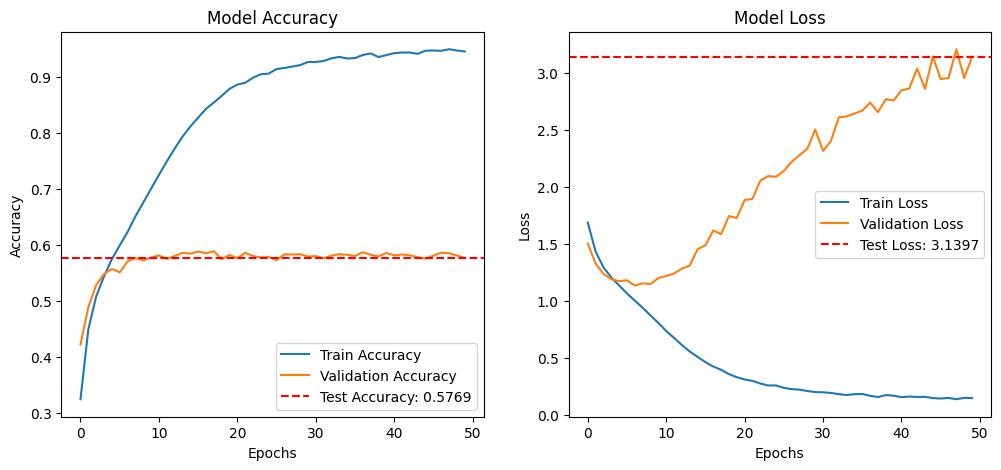

In [19]:
# Plot Accuracy and Loss Curves
def plot_model_performance(test_history):
    # Accuracy Graph
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(test_history.history['accuracy'], label='Train Accuracy')
    plt.plot(test_history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Graph
    plt.subplot(1, 2, 2)
    plt.plot(test_history.history['loss'], label='Train Loss')
    plt.plot(test_history.history['val_loss'], label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_model_performance(history)

In [20]:
# Train the model and store the history
history2 = emotion_model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/2
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 175ms/step - accuracy: 0.9539 - loss: 0.1268 - val_accuracy: 0.5759 - val_loss: 3.4541
Epoch 2/2
449/449 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - accuracy: 0.9509 - loss: 0.1350 - val_accuracy: 0.5800 - val_loss: 3.1215


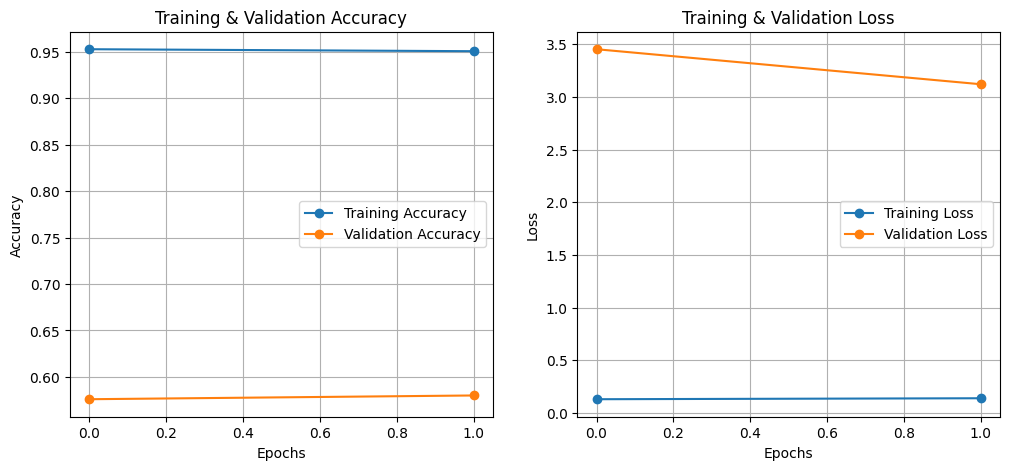

In [22]:
# Plot Accuracy Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss', marker='o')
plt.plot(history2.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

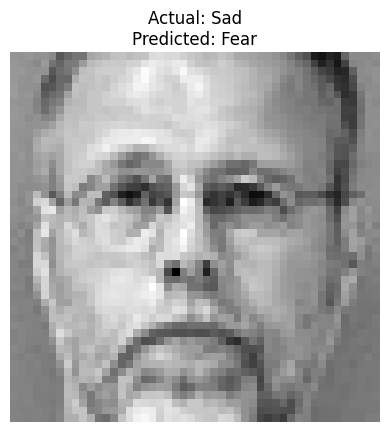

Actual Emotion: Sad
Predicted Emotion: Fear
Prediction Confidence: 0.4371


In [26]:
# Function to predict and display emotion with actual label
def predict_emotion(index=None):
    if index is None:
        index = random.randint(0, len(X_test) - 1)  # Random image if no index provided

    # Prepare the image for prediction
    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image, verbose=0)

    # Get predicted and actual labels
    predicted_label = emotion_labels[np.argmax(prediction)]
    actual_label = emotion_labels[np.argmax(y_test[index])]

    # Display the image with prediction and actual label
    plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
    plt.axis("off")
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.show()

    print(f"Actual Emotion: {actual_label}")
    print(f"Predicted Emotion: {predicted_label}")
    print(f"Prediction Confidence: {prediction[0][np.argmax(prediction)]:.4f}")

predict_emotion()

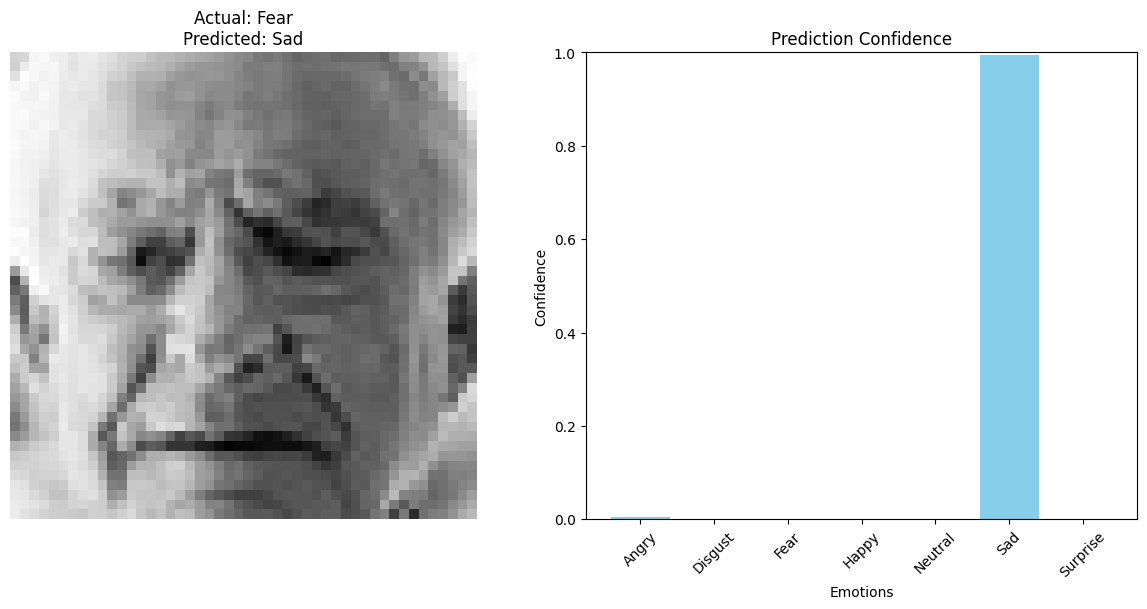

Actual Emotion: Fear
Predicted Emotion: Sad
Confidence Scores: {'Angry': 0.004217081, 'Disgust': 2.590056e-08, 'Fear': 0.0003930911, 'Happy': 4.9527507e-09, 'Neutral': 7.057079e-08, 'Sad': 0.9953897, 'Surprise': 2.3996476e-17}


In [31]:
# Function to predict emotion and display confidence bar chart
def predict_emotion_with_confidence(index=None):
    if index is None:
        index = random.randint(0, len(X_test) - 1)  # Select random image if no index is provided

    # Prepare the image for prediction
    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image, verbose=0)

    # Get predicted and actual labels
    predicted_label = emotion_labels[np.argmax(prediction)]
    actual_label = emotion_labels[np.argmax(y_test[index])]

    # Display the image
    plt.figure(figsize=(12, 6))

    # Image subplot
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
    plt.axis("off")
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

    # Bar plot for confidence levels
    plt.subplot(1, 2, 2)
    plt.bar(emotion_labels, prediction[0], color='skyblue')
    plt.ylabel("Confidence")
    plt.xlabel("Emotions")
    plt.title("Prediction Confidence")
    plt.ylim(0, 1)  # Confidence ranges from 0 to 1
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Actual Emotion: {actual_label}")
    print(f"Predicted Emotion: {predicted_label}")
    print(f"Confidence Scores: {dict(zip(emotion_labels, prediction[0]))}")

# Call the function to predict and visualize
predict_emotion_with_confidence()

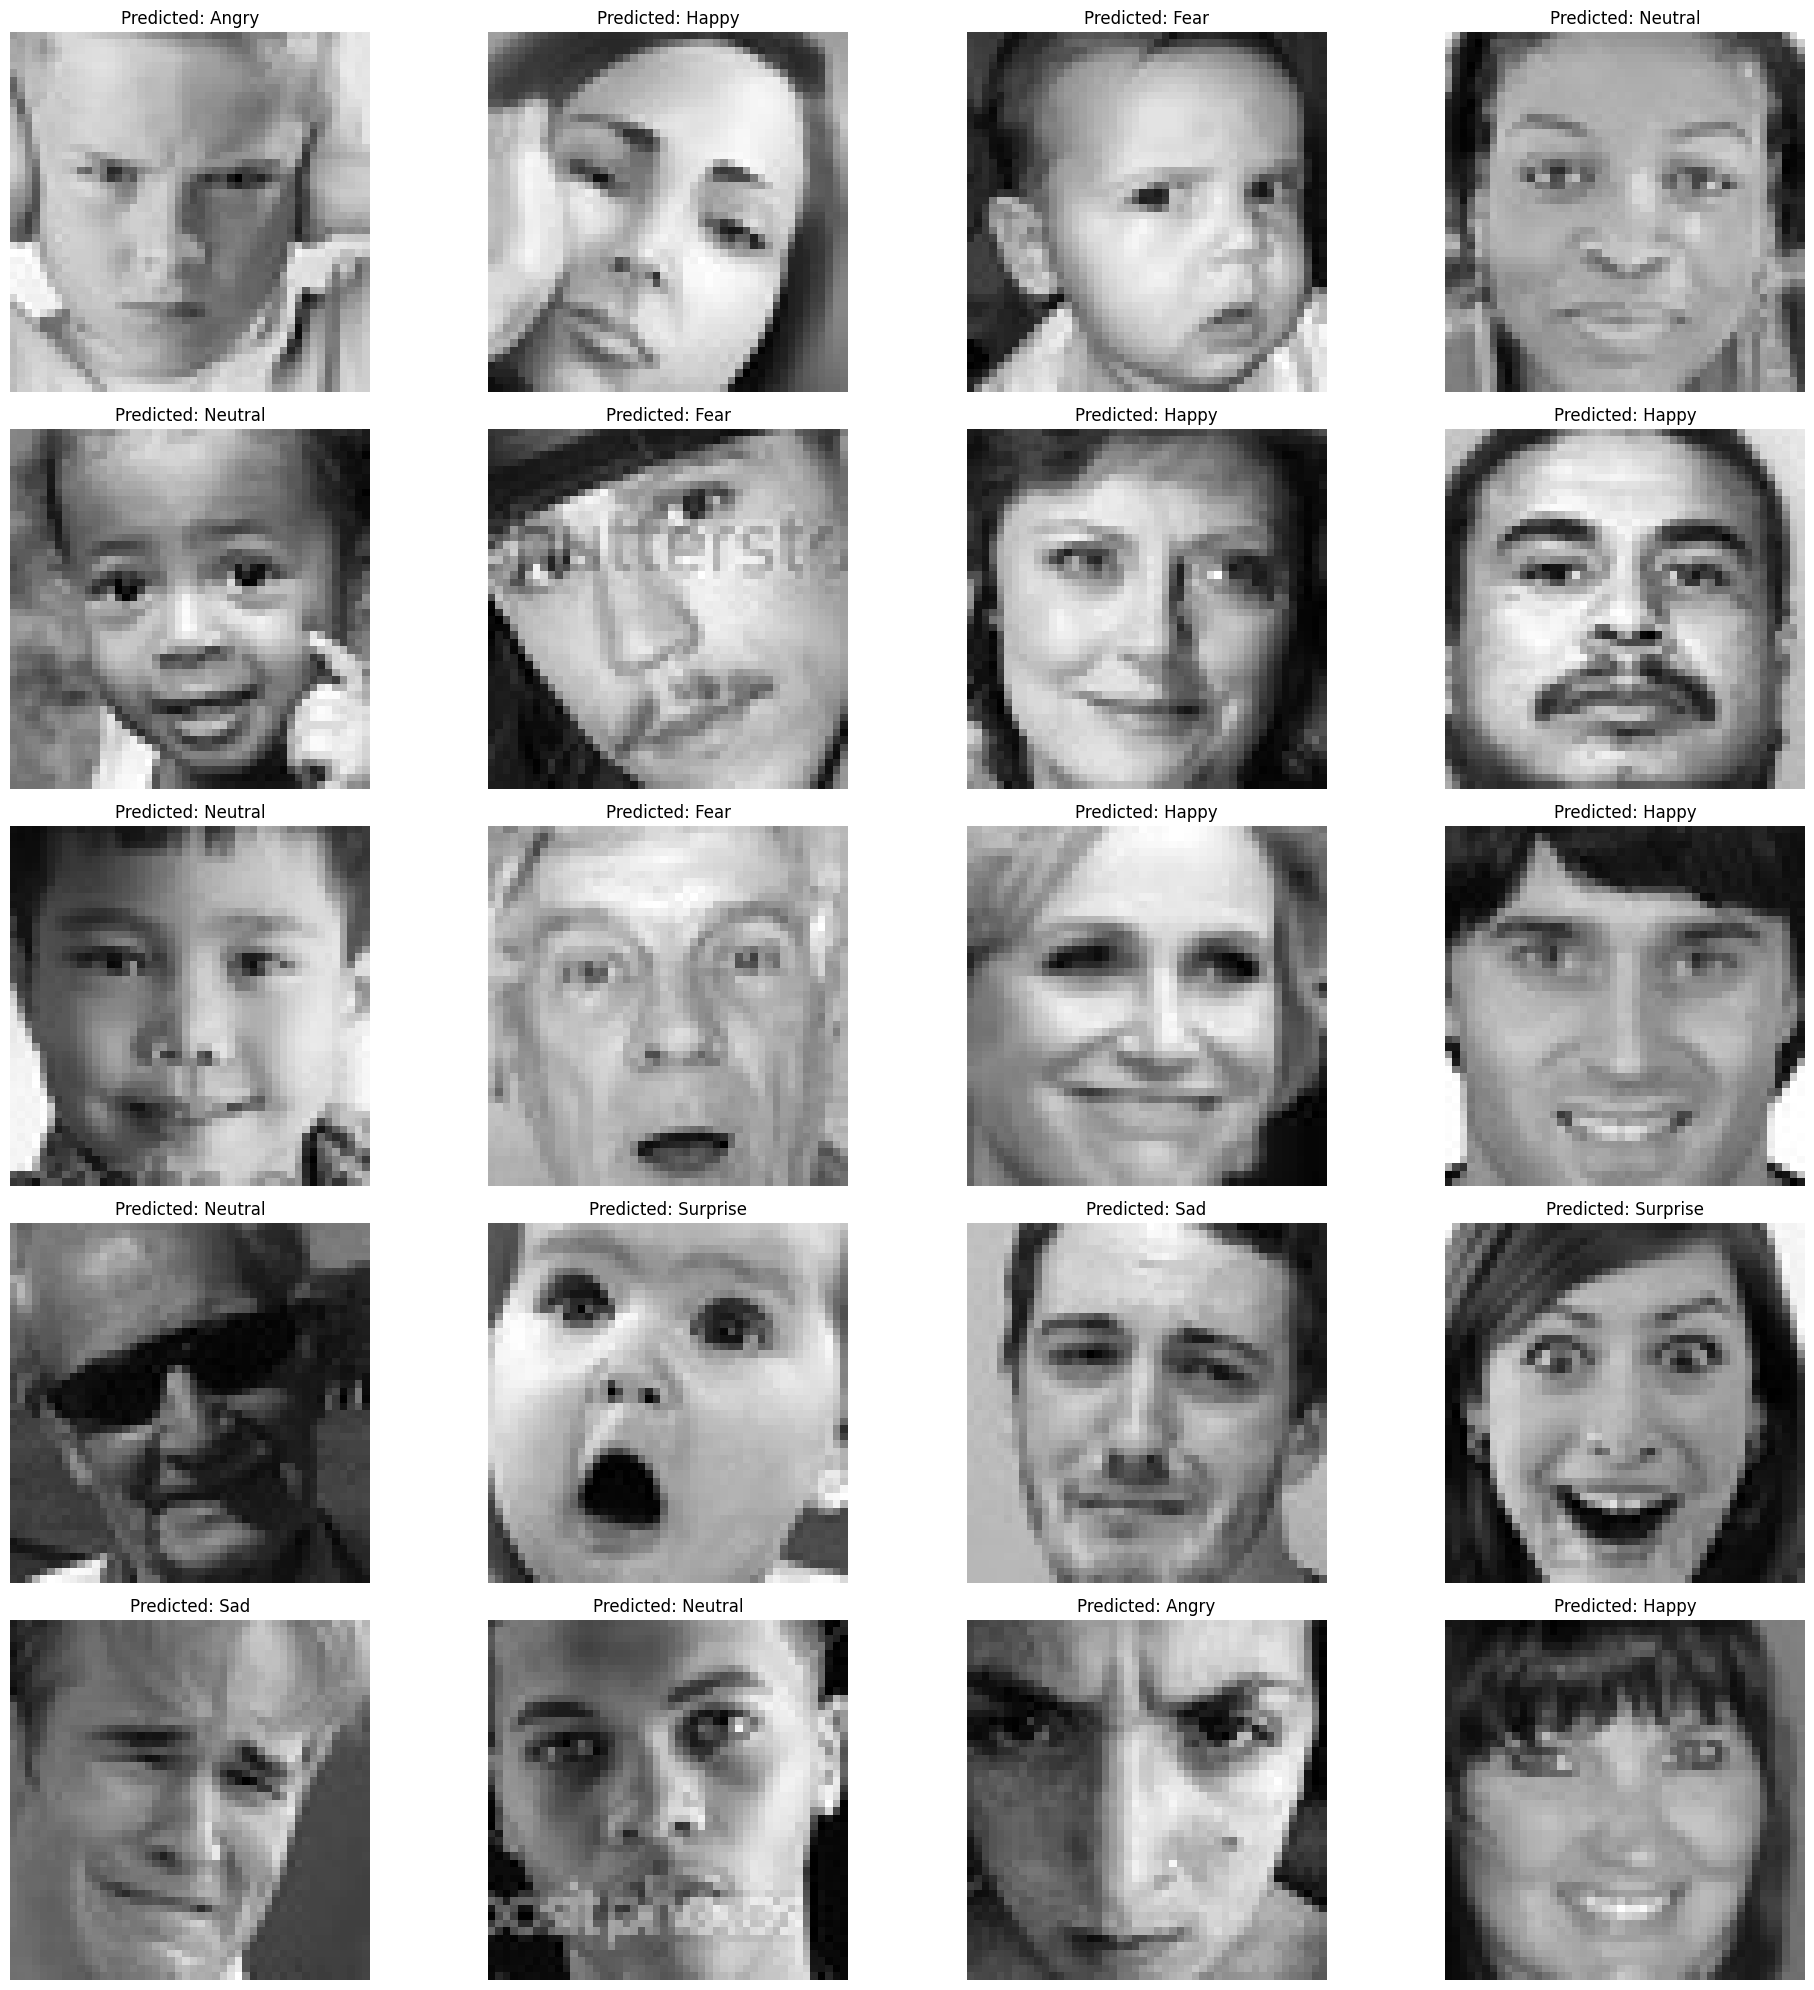

In [ ]:
# Function to predict and display 20 random images with their predicted emotions
def predict_multiple_emotions(num_images=20):
    plt.figure(figsize=(20, 20))

    for i in range(num_images):
        index = random.randint(0, len(X_test) - 1)  # Select a random index

        # Prepare the image for prediction
        test_image = np.expand_dims(X_test[index], axis=0)
        prediction = emotion_model.predict(test_image, verbose=0)
        predicted_label = emotion_labels[np.argmax(prediction)]

        # Display the image with prediction
        plt.subplot(5, 4, i + 1)
        plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
        plt.axis("off")
        plt.title(f"Predicted: {predicted_label}")

    plt.tight_layout()
    plt.show()

# Call the function to display 20 images
predict_multiple_emotions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


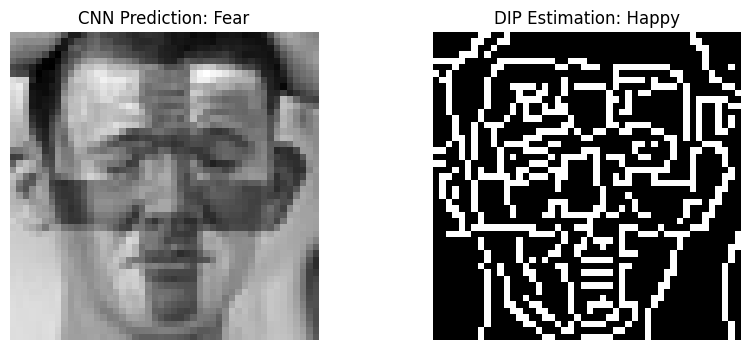

📌 CNN Model Predicted: Fear
📌 DIP-Based Estimation: Happy


In [ ]:
def dip_based_estimation(gray_img):
    """Estimate emotion using basic DIP techniques."""
    edges = cv2.Canny(gray_img, 50, 150)  # Apply Canny Edge Detection
    mean_intensity = np.mean(gray_img)  # Average brightness
    edge_count = np.sum(edges > 100)  # Count strong edges

    # Simple rule-based emotion classification
    if edge_count > 1500 and mean_intensity < 80:
        return "Angry"
    elif edge_count < 500 and mean_intensity > 150:
        return "Neutral"
    elif edge_count > 1800:
        return "Surprise"
    elif mean_intensity < 50:
        return "Sad"
    else:
        return "Happy"

def predict_emotion(index=None):
    """Predict emotion using CNN and compare with DIP-based estimation."""
    if index is None:
        index = random.randint(0, len(X_test) - 1)

    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image)
    cnn_predicted_label = emotion_labels[np.argmax(prediction)]

    # Convert image to grayscale for DIP processing
    gray_img = X_test[index].reshape(48, 48) * 255  # Convert back to 8-bit range
    dip_predicted_label = dip_based_estimation(gray_img.astype(np.uint8))

    # Display results
    plt.figure(figsize=(10, 4))

    # CNN Prediction
    plt.subplot(1, 2, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.axis("off")
    plt.title(f"CNN Prediction: {cnn_predicted_label}")

    # DIP Prediction
    edges = cv2.Canny(gray_img.astype(np.uint8), 50, 150)
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    plt.title(f"DIP Estimation: {dip_predicted_label}")

    plt.show()

    # Print comparison
    print(f"📌 CNN Model Predicted: {cnn_predicted_label}")
    print(f"📌 DIP-Based Estimation: {dip_predicted_label}")

# Run on a random image
predict_emotion()